In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import warnings
import multiprocessing as mp

In [2]:
noiseVariance = 13
interVariance = 157
slopeVariance = 1.2
interSlopeCovariance = -1.3
numTimePoints = 10
numPatients = 100
slope = -1.2
intercept = 109
xOfProtocol = 5
alpha = 1.02
numCounts = 0

## Linear Regression Cost Function
$$ \alpha_iy_0 = y_i = \beta_0 + \beta_1t_i + \beta_2P_i + r_i $$

Where P is a sparse matrix where a value of 1 indicates the data point belongs to the second protocol

## Log Linear Regression Cost Function
$$ ln(\alpha_i) + ln(y_0) = y_i = \beta_0 + \beta_1t_i + \beta_2P_i + r_i $$

Taking the natural logarith of the data makes alpha an additive factor which is more accurately modeled by the additive (beta2 x P) term

## Mixed Model Cost Function
$$
\alpha_{ij}y_0 = y_{ij} = P_i\beta_2 + Zu_{j} + r_i
$$

$$
Zu = \beta_0 + \beta_1t_i + \beta_3G
$$


For the i time point and j patient. Beta 2 is the coefficiant of the fixed effect P (what protocol the data point is in). Z is a matrix of coefficants of the random effects. The random effects are the intercept(beta 0, slope(beta 1), and what patient the data point  belongs to(beta 3)

## Converting Non-log Coefficiants
$$
\beta_1 = \beta_1'
$$

$$
\alpha_2 = 1 + \dfrac{\beta_0P_2}{\beta_0 + \beta_1\overline{t_2}}
$$

Formulas for converting regression coefficiants into true slope and alpha. Formulas are derived from minimizing the sum of the squared residuals.

## Converting Log Coefficiants
$$ \beta_1 = \dfrac{\beta_1'}{\overline{(1/y)}} $$

$$ \alpha = e^{\beta_2} $$

Formulas for converting regression coefficiants into true slope and alpha. Formulas are derived from minimizing the sum of the squared residuals.

## True Y in terms of alpha
$$ y_i = \beta_0 + \dfrac{\beta_1t_i}{\alpha_2} + \beta_1\overline{t_2}(1-\dfrac{1}{\alpha}) $$

## Data Generation Function
$$
y_{ij} = 109 + N(0, \sqrt{157}) + (-1.2 +N(0, \sqrt{1.2}))\cdot t_j + N(0, \sqrt{13})
$$

Does not account for intercept-slope covariance generation

In [3]:
def generateCorrelatedData():
    global sigma, interVariance, slopeVariance, interSlopeCovariance, numTimePoints, numPatients, slope, intercept, xOfProtocol, alpha
    mean = [intercept, slope]
    variance = [[interVariance, interSlopeCovariance],
                [interSlopeCovariance, slopeVariance]]
    interSlopeList = np.random.multivariate_normal(mean, variance, 100)
    interList, slopeList = np.hsplit(interSlopeList, 2)
    interList = interList.reshape(100)
    slopeList = slopeList.reshape(100)
    covarianceList = np.cov(interList, slopeList)
    return interList, slopeList, covarianceList

In [4]:
def createData(interList, slopeList):
    global noiseVariance, interVariance, slopeVariance, interSlopeCovariance, numTimePoints, numPatients, slope, intercept, xOfProtocol, alpha
    np.random.seed()
    numDataPoints = numPatients*numTimePoints
    noise = np.random.normal(0, np.sqrt(noiseVariance), numDataPoints)
    
    protList = []
    protList2 = []
    xList = []
    t2List = []
    yList = []
    patientList = []
    oneYAveList = []
    slope1List = []
    alpha1List = []
    slope2List = []
    alpha2List = []
    correctedYList = []
    for j in range(numPatients):
        patientProtList = []
        patientProtList2 = []
        patientXList = []
        patientYData = []
        patientT2List = []
        patientPatientList = []
        for i in range(numTimePoints):
            patientXList.append(i)
            patientPatientList.append(j)
            if i < xOfProtocol:
                patientProtList.append(0)
                patientProtList2.append([i, 0])
                patientYData.append((interList[j]) +((slopeList[j]*i))+noise[(j*10)+i])
            else:
                patientProtList.append(1)
                patientProtList2.append([i, 1])
                patientT2List.append(i)
                patientYData.append(((interList[j]) +((slopeList[j]*i))+noise[(j*10)+i])*alpha)
        protList.append(patientProtList)
        protList2.append(patientProtList2)
        xList.append(patientXList)
        yList.append(patientYData)
        patientT2Ave = np.average(patientT2List)
        t2List.append(patientT2List)
        patientList.append(patientPatientList)
        
        yAcc = 0
        for yValue in patientYData:
            yAcc = yAcc + (1/yValue)
        patientOneYAve = yAcc / (numTimePoints)
        oneYAveList.append(patientOneYAve)
        
        
        #Un Logged
        reg = linear_model.LinearRegression()
        reg.fit(patientProtList2, patientYData)
        coef1 = reg.coef_[0]
        coef2 = reg.coef_[1]
        inter = reg.intercept_
        predictedYData = reg.predict(patientProtList2)
        slope1 = coef1
        alpha1 = (1+(coef2/(inter +(coef1*patientT2Ave))))
        slope1List.append(slope1)
        alpha1List.append(alpha1)
        
        #Un Logged Correction
        correctedPatientYList = []
        correctedSlope1List = []
        for i in range(numTimePoints):
            if i < xOfProtocol:
                correctedPatientYList.append(yList[j][i])
            else:
                correctedPatientYList.append((yList[j][i]/alpha1))
        correctedYList.append(correctedPatientYList)
        
        reg = linear_model.LinearRegression()
        reg.fit(patientProtList2, correctedPatientYList)
        coef1 = reg.coef_[0]
        coef2 = reg.coef_[1]
        inter = reg.intercept_
        correctedPredictedYData = reg.predict(patientProtList2)    
    
        yAcc = 0
        for yValue in correctedPatientYList:
            yAcc = yAcc + (1/yValue)
        oneYAve = yAcc / (numTimePoints)
        
        correctedSlope1 = coef1
        correctedSlope1List.append(correctedSlope1)
        
        
        #Logged
        reg = linear_model.LinearRegression()
        reg.fit(patientProtList2, np.log(patientYData))
        coef1 = reg.coef_[0]
        coef2 = reg.coef_[1]
        inter = reg.intercept_
        predictedYData = reg.predict(patientProtList2)
        slope2 = (coef1/oneYAve)
        alpha2 = (np.e ** coef2)
        slope2List.append(slope2)
        alpha2List.append(alpha2)
        

        #Logged Corrected
        correctedPatientYList = []
        correctedSlope2List = []
        for i in range(numTimePoints):
            if i < xOfProtocol:
                correctedPatientYList.append(yList[j][i])
            else:
                correctedPatientYList.append((yList[j][i]/alpha2))
        correctedYList.append(correctedPatientYList)
        
        reg = linear_model.LinearRegression()
        reg.fit(patientProtList2, np.log(correctedPatientYList))
        coef1 = reg.coef_[0]
        coef2 = reg.coef_[1]
        inter = reg.intercept_
        correctedPredictedYData = reg.predict(patientProtList2)    
    
        yAcc = 0
        for yValue in correctedPatientYList:
            yAcc = yAcc + (1/yValue)
        oneYAve = yAcc / (numTimePoints)
        
        correctedSlope2 = (coef1/oneYAve)
        correctedSlope2List.append(correctedSlope2)
            
    tAve = np.average(t2List)
    oneYAve = np.average(oneYAveList)
    averageSlope1 = np.average(slope1List)
    averageAlpha1 = np.average(alpha1List)
    averageCorrectedSlope1 = np.average(correctedSlope1List)
    averageSlope2 = np.average(slope2List)
    averageAlpha2 = np.average(alpha2List)
    averageCorrectedSlope2 = np.average(correctedSlope2List)
    
    return [[yList, xList, protList, patientList, tAve, oneYAve], 
            [averageSlope1, averageAlpha1, averageCorrectedSlope1],
           [averageSlope2, averageAlpha2, averageCorrectedSlope2]]


In [5]:
def convertToCSV(yList, xList, protList, patientList):
    yData = np.array(yList)
    yData = yData.reshape(-1,1)
    xData = np.array(xList)
    xData = xData.reshape(-1,1)
    protocol = np.array(protList)
    protocol = protocol.reshape(-1, 1)
    patient = np.array(patientList)
    patient = patient.reshape(-1, 1)
    stack = np.dstack((yData, xData, protocol, patient))
    stack = stack.reshape(-1,4)
    jointData = pd.DataFrame(stack, columns=["brain_volume","time","protocol", "patient"])
#     csv = jointData.to_csv(index=False, path_or_buf= "/Users/nadavskloot/Desktop/Patient_Data.csv")
#     jointData = pd.read_csv("/Users/nadavskloot/Desktop/Patient_Data.csv")
    return jointData, xData, yData

In [6]:
def allModelsRegression(plot):
    global noiseVariance, interVariance, slopeVariance, interSlopeCovariance, numTimePoints, numPatients, slope, intercept, xOfProtocol, alpha
    global numCounts
    interList, slopeList, covarianceList = generateCorrelatedData()
    [[yList, xList, protList, patientList, t2Ave, oneYAve], [averageSlope1, averageAlpha1, averageCorrectedSlope1],
           [averageSlope2, averageAlpha2, averageCorrectedSlope2]] = createData(interList, slopeList)
    data, xData, yData = convertToCSV(yList, xList, protList, patientList)
    
    #Un Logged
    data["intercept"] = 1
    md = sm.MixedLM(data["brain_volume"], data[["intercept", "time", "protocol"]], groups=data["patient"], exog_re=data[["intercept", "time"]])
    mdf = md.fit(full_output= True)
    fittedValues = np.array(mdf.fittedvalues).reshape(100,10)
    [coef0, coef1, coef2] = mdf.fe_params.tolist()    
    
    #convert coeficients
    covMatrix = mdf.cov_re.to_numpy()
    interVar2 = covMatrix[0][0]
    slopeVar2 = covMatrix[1][1]
    covariance2 = covMatrix[0][1]
    slope3 = coef1
    alpha3 = (1+(coef2/(coef0 +(coef1*t2Ave))))

    #Un Logged Correction
    correctedYList = []
    for j in range(numPatients):
        for i in range(numTimePoints):
            if i < xOfProtocol:
                correctedYList.append(yList[j][i])
            else:
                correctedYList.append((yList[j][i]/alpha3))
    
    data, xData, yData = convertToCSV(correctedYList, xList, protList, patientList)
    data["intercept"] = 1
    md = sm.MixedLM(data["brain_volume"], data[["intercept", "time", "protocol"]], groups=data["patient"], exog_re=data[["intercept", "time"]])
    mdf = md.fit(full_output= True)
    fittedValues = np.array(mdf.fittedvalues).reshape(100,10)
    [coef0, coef1, coef2] = mdf.fe_params.tolist()
    
    
    interVar1 = covarianceList[0][0]
    slopeVar1 = covarianceList[1][1]
    covariance1 = covarianceList[0][1]
    
    correctedSlope3 = coef1
    
    
    #Logged
    data, xData, yData = convertToCSV(np.log(np.array(yList)), xList, protList, patientList)
    
    data["intercept"] = 1
    md = sm.MixedLM(data["brain_volume"], data[["intercept", "time", "protocol"]], groups=data["patient"], exog_re=data[["intercept", "time"]])
    mdf = md.fit(full_output= True)
    fittedValues = np.array(mdf.fittedvalues).reshape(100,10)
    [coef0, coef1, coef2] = mdf.fe_params.tolist()
    
    #convert coeficients
    covMatrix = mdf.cov_re.to_numpy()
    interVar2 = covMatrix[0][0]
    slopeVar2 = covMatrix[1][1]
    covariance2 = covMatrix[0][1]
    slope4 = (coef1/oneYAve)
    alpha4 = (np.e ** coef2)

    correctedYList = []
    for j in range(numPatients):
        for i in range(numTimePoints):
            if i < xOfProtocol:
                correctedYList.append(yList[j][i])
            else:
                correctedYList.append((yList[j][i]/alpha4))

    yAcc = 0
    for yValue in correctedYList:
        yAcc = yAcc + (1/yValue)
    oneYAve = yAcc / (numTimePoints*numPatients)

            
    data, xData, yData = convertToCSV(np.log(np.array(correctedYList)), xList, protList, patientList)
    data["intercept"] = 1
    md = sm.MixedLM(data["brain_volume"], data[["intercept", "time", "protocol"]], groups=data["patient"], exog_re=data[["intercept", "time"]])
    mdf = md.fit(full_output= True)
    fittedValues = np.array(mdf.fittedvalues).reshape(100,10)
    [coef0, coef1, coef2] = mdf.fe_params.tolist()
    
    
    interVar1 = covarianceList[0][0]
    slopeVar1 = covarianceList[1][1]
    covariance1 = covarianceList[0][1]
    
    correctedSlope4 = (coef1/oneYAve)
    
    numCounts += 1
    print("finished computing the correction for the {0} time".format(numCounts))
    
    return [[averageSlope1, averageAlpha1, averageCorrectedSlope1],
           [averageSlope2, averageAlpha2, averageCorrectedSlope2],
           [slope3, alpha3, correctedSlope3],
           [slope4, alpha4, correctedSlope4]]


In [7]:
warnings.filterwarnings('ignore')
allModelsRegression(True)

finished computing the correction for the 1 time


[[-1.2789926779168048, 1.0184832427275265, -4.098152448700303],
 [-1.251215777330411, 1.017111424145398, -4.162289185361669],
 [-1.2789926779168452, 1.017276546634989, -1.266983927723494],
 [-1.300796466203122, 1.0158297482315943, -1.2903232450269784]]

In [8]:
def loopRegression(loops):
    warnings.filterwarnings('ignore')
    p = mp.Pool(mp.cpu_count())
    outputList = p.map(allModelsRegression, (False for i in range(loops)))
    allOutputList = np.stack(np.array(outputList), axis= -1)

    valueDict = {"slope1": {}, "alpha1": {}, "correctedSlope1": {}, "slope2": {}, "alpha2": {}, "correctedSlope2": {},
                 "slope3": {}, "alpha3": {}, "correctedSlope3": {}, "slope4": {}, "alpha4": {}, "correctedSlope4": {}}
    valueKeysList = list(valueDict.keys())
    for i in range(len(valueKeysList)):
        valueDict[valueKeysList[i]]["Mean"] = np.average(allOutputList[i//3][i%3])
        Array = np.array(allOutputList[i//3][i%3])
        valueDict[valueKeysList[i]]["StDev"] = np.std(Array)
        valueDict[valueKeysList[i]]["ConInt"] = (valueDict[valueKeysList[i]]["Mean"] - (1.96 * valueDict[valueKeysList[i]]["StDev"]), valueDict[valueKeysList[i]]["Mean"] + (1.96 * valueDict[valueKeysList[i]]["StDev"]))
        valueDict[valueKeysList[i]]["Data"] = allOutputList[i//3][i%3]
    return valueDict


In [9]:
valueDict = loopRegression(1000)

finished computing the correction for the 2 time
finished computing the correction for the 2 time
finished computing the correction for the 2 time
finished computing the correction for the 2 time
finished computing the correction for the 3 time
finished computing the correction for the 3 time
finished computing the correction for the 3 time
finished computing the correction for the 3 time
finished computing the correction for the 4 time
finished computing the correction for the 4 time
finished computing the correction for the 4 time
finished computing the correction for the 4 time
finished computing the correction for the 5 time
finished computing the correction for the 5 time
finished computing the correction for the 5 time
finished computing the correction for the 5 time
finished computing the correction for the 6 time
finished computing the correction for the 6 time
finished computing the correction for the 6 time
finished computing the correction for the 6 time
finished computing t

finished computing the correction for the 56 time
finished computing the correction for the 43 time
finished computing the correction for the 57 time
finished computing the correction for the 44 time
finished computing the correction for the 58 time
finished computing the correction for the 45 time
finished computing the correction for the 59 time
finished computing the correction for the 46 time
finished computing the correction for the 60 time
finished computing the correction for the 47 time
finished computing the correction for the 61 time
finished computing the correction for the 48 time
finished computing the correction for the 62 time
finished computing the correction for the 49 time
finished computing the correction for the 38 time
finished computing the correction for the 50 time
finished computing the correction for the 39 time
finished computing the correction for the 36 time
finished computing the correction for the 51 time
finished computing the correction for the 40 time


finished computing the correction for the 59 time
finished computing the correction for the 98 time
finished computing the correction for the 105 time
finished computing the correction for the 75 time
finished computing the correction for the 60 time
finished computing the correction for the 99 time
finished computing the correction for the 106 time
finished computing the correction for the 61 time
finished computing the correction for the 100 time
finished computing the correction for the 76 time
finished computing the correction for the 107 time
finished computing the correction for the 101 time
finished computing the correction for the 62 time
finished computing the correction for the 77 time
finished computing the correction for the 108 time
finished computing the correction for the 102 time
finished computing the correction for the 63 time
finished computing the correction for the 78 time
finished computing the correction for the 109 time
finished computing the correction for the 

finished computing the correction for the 127 time
finished computing the correction for the 100 time
finished computing the correction for the 141 time
finished computing the correction for the 131 time
finished computing the correction for the 128 time
finished computing the correction for the 101 time
finished computing the correction for the 142 time
finished computing the correction for the 132 time
finished computing the correction for the 129 time
finished computing the correction for the 102 time
finished computing the correction for the 143 time
finished computing the correction for the 133 time
finished computing the correction for the 130 time
finished computing the correction for the 103 time
finished computing the correction for the 144 time
finished computing the correction for the 134 time
finished computing the correction for the 104 time
finished computing the correction for the 131 time
finished computing the correction for the 145 time
finished computing the correcti

finished computing the correction for the 144 time
finished computing the correction for the 165 time
finished computing the correction for the 145 time
finished computing the correction for the 166 time
finished computing the correction for the 146 time
finished computing the correction for the 167 time
finished computing the correction for the 147 time
finished computing the correction for the 168 time
finished computing the correction for the 148 time
finished computing the correction for the 169 time
finished computing the correction for the 149 time
finished computing the correction for the 170 time
finished computing the correction for the 159 time
finished computing the correction for the 150 time
finished computing the correction for the 171 time
finished computing the correction for the 160 time
finished computing the correction for the 151 time
finished computing the correction for the 172 time
finished computing the correction for the 161 time
finished computing the correcti

finished computing the correction for the 219 time
finished computing the correction for the 222 time
finished computing the correction for the 187 time
finished computing the correction for the 193 time
finished computing the correction for the 220 time
finished computing the correction for the 188 time
finished computing the correction for the 221 time
finished computing the correction for the 194 time
finished computing the correction for the 189 time
finished computing the correction for the 190 time
finished computing the correction for the 222 time
finished computing the correction for the 195 time
finished computing the correction for the 191 time
finished computing the correction for the 196 time
finished computing the correction for the 223 time
finished computing the correction for the 192 time
finished computing the correction for the 224 time
finished computing the correction for the 197 time
finished computing the correction for the 193 time
finished computing the correcti

finished computing the correction for the 235 time
finished computing the correction for the 236 time
finished computing the correction for the 237 time
finished computing the correction for the 238 time
finished computing the correction for the 239 time
finished computing the correction for the 240 time
finished computing the correction for the 241 time
finished computing the correction for the 242 time
finished computing the correction for the 243 time
finished computing the correction for the 244 time
finished computing the correction for the 245 time
finished computing the correction for the 239 time
finished computing the correction for the 246 time
finished computing the correction for the 240 time
finished computing the correction for the 247 time
finished computing the correction for the 241 time
finished computing the correction for the 248 time
finished computing the correction for the 242 time
finished computing the correction for the 249 time
finished computing the correcti

In [10]:
def displayData(valueDict, parameter):
    plt.hist(valueDict[parameter]["Data"])
    plt.xlabel(parameter[:-1])
    plt.ylabel("frequency")
    if parameter[-1] == "1":
        plt.title("Unlogged 100 Linear Regression")
    elif parameter[-1] == "2":
        plt.title("Logged 100 Linear Regression")
    elif parameter[-1] == "3":
         plt.title("Unlogged Mixed Model")
    else:
        plt.title("Logged Mixed Model")
    print("Mean:", valueDict[parameter]["Mean"])
    print("StDev:", valueDict[parameter]["StDev"])
    print("ConInt:", valueDict[parameter]["ConInt"])

Mean: -1.2524128930041798
StDev: 1.3058817618798495
ConInt: (-3.811941146288685, 1.3071153602803254)


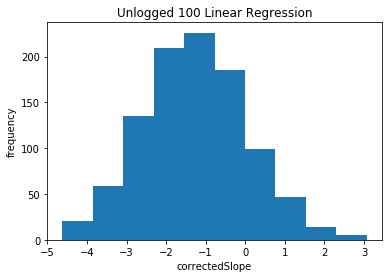

In [11]:
displayData(valueDict, "correctedSlope1")

Mean: -1.252379375708781
StDev: 1.306780393344219
ConInt: (-3.8136689466634506, 1.3089101952458881)


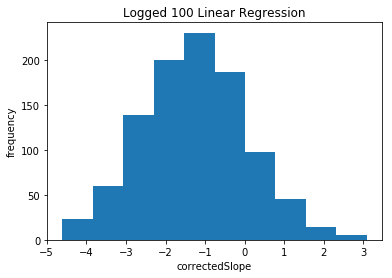

In [12]:
displayData(valueDict, "correctedSlope2")

Mean: -1.198681950617122
StDev: 0.13430558865290562
ConInt: (-1.461920904376817, -0.9354429968574269)


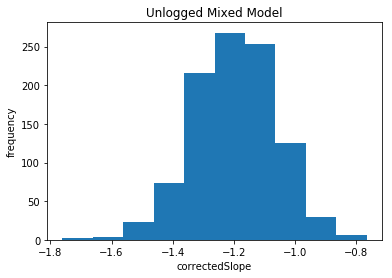

In [13]:
displayData(valueDict, "correctedSlope3")

Mean: -1.2419575381302408
StDev: 0.13591721912300173
ConInt: (-1.5083552876113242, -0.9755597886491574)


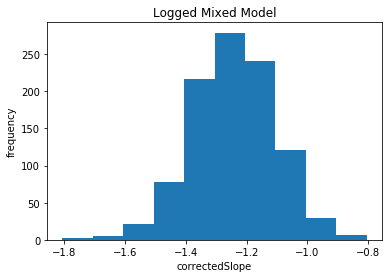

In [14]:
displayData(valueDict, "correctedSlope4")

Mean: 1.0225888200338809
StDev: 0.004965139374968292
ConInt: (1.012857146858943, 1.0323204932088188)


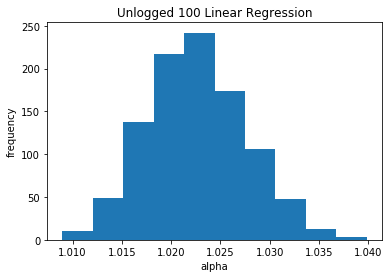

In [16]:
displayData(valueDict, "alpha1")

Mean: 1.0210633254345032
StDev: 0.00473353839443679
ConInt: (1.011785590181407, 1.0303410606875993)


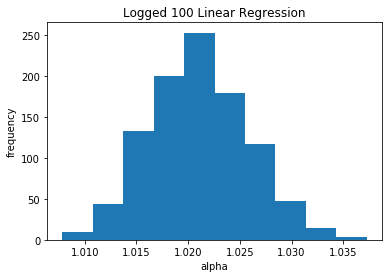

In [17]:
displayData(valueDict, "alpha2")

Mean: 1.020481144806041
StDev: 0.004760228316186873
ConInt: (1.0111510973063147, 1.0298111923057671)


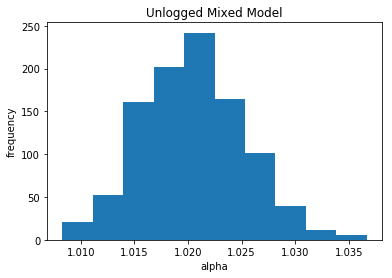

In [18]:
displayData(valueDict, "alpha3")

Mean: 1.019989914597157
StDev: 0.004725966493868448
ConInt: (1.0107270202691747, 1.0292528089251392)


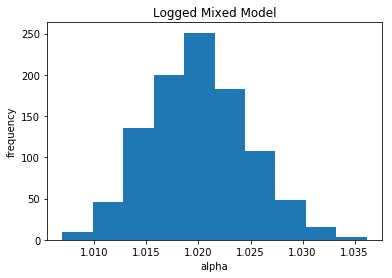

In [19]:
displayData(valueDict, "alpha4")